/var/folders/nk/vwtp7n_53_18f4kxcylrscmm0000gn/T/ipykernel_7215/508208293.py:19: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=data_dir)


Extraction complete.
Expression matrix shape: (2702, 32285)
Example genes: ['Xkr4', 'Gm1992', 'Gm19938']
Example barcodes: ['AAACAAGTATCTCCCA-1', 'AAACAATCTACTAGCA-1', 'AAACACCAATAACTGC-1']
Empty DataFrame
Columns: [barcode, in_tissue, array_row, array_col, pxl_row, pxl_col, x_coord, y_coord]
Index: []


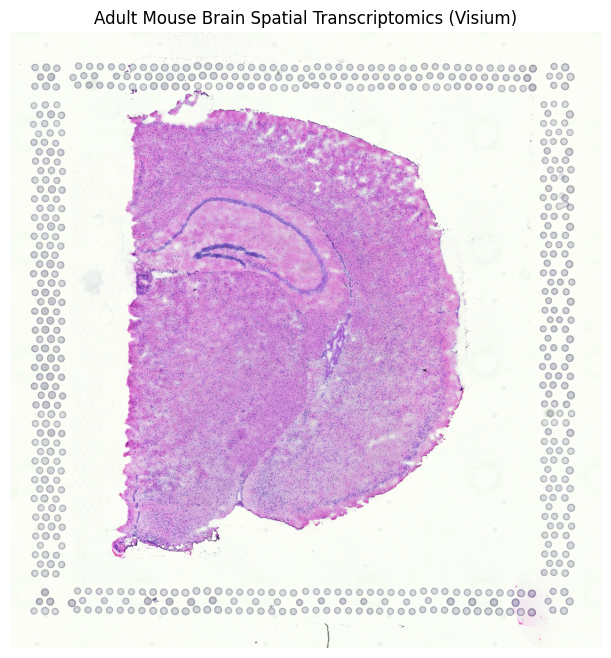

In [2]:
import tarfile
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import mmread
from PIL import Image
import json
import os

# === 1. Extract all files ===
data_dir = "Mouse Data"
tar_files = [
    f"{data_dir}/V1_Adult_Mouse_Brain_filtered_feature_bc_matrix.tar",
    f"{data_dir}/V1_Adult_Mouse_Brain_spatial.tar"
]
for f in tar_files:
    with tarfile.open(f) as tar:
        tar.extractall(path=data_dir)
print("Extraction complete.")

# === 2. Load expression matrix ===
matrix_path = f"{data_dir}/filtered_feature_bc_matrix/matrix.mtx.gz"
barcodes_path = f"{data_dir}/filtered_feature_bc_matrix/barcodes.tsv.gz"
features_path = f"{data_dir}/filtered_feature_bc_matrix/features.tsv.gz"

matrix = mmread(gzip.open(matrix_path)).T.tocsr()
barcodes = pd.read_csv(barcodes_path, header=None)[0].tolist()
features = pd.read_csv(features_path, sep='\t', header=None)[1].tolist()

print(f"Expression matrix shape: {matrix.shape}")
print(f"Example genes: {features[:3]}")
print(f"Example barcodes: {barcodes[:3]}")

# === 3. Load spatial coordinates ===
coords_path = f"{data_dir}/spatial/tissue_positions.csv"
coords = pd.read_csv(coords_path, header=None)
coords.columns = ["barcode", "in_tissue", "array_row", "array_col", "pxl_row", "pxl_col"]
coords = coords[coords["in_tissue"] == 1]  # keep only spots on tissue

# === 4. Load scaling factors and image ===
scale_factors_path = f"{data_dir}/spatial/scalefactors_json.json"
with open(scale_factors_path) as f:
    scale = json.load(f)
spot_diam = scale["spot_diameter_fullres"]

image_path = f"{data_dir}/spatial/tissue_hires_image.png"
img = np.array(Image.open(image_path))

# === 5. Merge coordinates with expression ===
coords["x_coord"] = coords["pxl_col"]
coords["y_coord"] = coords["pxl_row"]
print(coords.head())

# === 6. Visualize ===
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.scatter(coords["x_coord"], coords["y_coord"], s=spot_diam*3, edgecolor="white", facecolor="none", alpha=0.6)
plt.title("Adult Mouse Brain Spatial Transcriptomics (Visium)")
plt.axis("off")
plt.show()

In [11]:
import gzip
import json
import pandas as pd
from scipy.io import mmread

# ====== 1. Load the expression matrix ======
mtx_path = f"{data_dir}/filtered_feature_bc_matrix/matrix.mtx.gz"
barcodes_path = f"{data_dir}/filtered_feature_bc_matrix/barcodes.tsv.gz"
features_path = f"{data_dir}/filtered_feature_bc_matrix/features.tsv.gz"

# Read matrix and labels
matrix = mmread(mtx_path).tocsr()
genes = pd.read_csv(features_path, sep='\t', header=None, names=["gene_id", "gene_name", "feature_type"])
barcodes = pd.read_csv(barcodes_path, sep='\t', header=None, names=["barcode"])

# Combine small preview (first 10 genes × 10 barcodes)
preview_df = pd.DataFrame(matrix[:10, :10].toarray(), 
                          index=genes["gene_name"][:10], 
                          columns=barcodes["barcode"][:10])

print("\n=== Expression Matrix Preview (first 10 genes × 10 spots) ===")
display(preview_df)

print(f"\nMatrix shape: {matrix.shape} (genes × barcodes)\n")


# ====== 2. Pretty-print the JSON metadata ======
json_path = f"{data_dir}/spatial/scalefactors_json.json"
print(f"=== Spatial Metadata JSON ===\n")

with open(json_path, "r") as f:
    data = json.load(f)

# show in a readable dictionary layout
for k, v in data.items():
    print(f"{k:30}: {v}")


=== Expression Matrix Preview (first 10 genes × 10 spots) ===


barcode,AAACAAGTATCTCCCA-1,AAACAATCTACTAGCA-1,AAACACCAATAACTGC-1,AAACAGAGCGACTCCT-1,AAACCGGGTAGGTACC-1,AAACCGTTCGTCCAGG-1,AAACCTCATGAAGTTG-1,AAACGAAGAACATACC-1,AAACGAGACGGTTGAT-1,AAACGGTTGCGAACTG-1
gene_name,,,,,,,,,,
Xkr4,0,0,0,0,0,0,0,1,0,0
Gm1992,0,0,0,0,0,0,0,0,0,0
Gm19938,0,1,0,0,0,0,0,0,1,0
Gm37381,0,0,0,0,0,0,0,0,0,0
Rp1,0,0,0,0,0,0,0,0,0,0
Sox17,0,0,0,0,0,0,1,0,1,0
Gm37587,0,0,0,0,0,0,0,0,0,0
Gm37323,0,0,0,0,0,0,0,0,0,0
Mrpl15,1,1,0,0,2,2,3,1,4,0



Matrix shape: (32285, 2702) (genes × barcodes)

=== Spatial Metadata JSON ===

tissue_hires_scalef           : 0.17011142
tissue_lowres_scalef          : 0.051033426
fiducial_diameter_fullres     : 144.47773811736502
spot_diameter_fullres         : 89.43859978694026


In [ ]:
import pandas as pd

tissue_path = f"{data_dir}/spatial/tissue_positions.csv"

tissue_df = pd.read_csv(
    tissue_path,
    header=None,
    names=["barcode", "in_tissue", "array_row", "array_col", "pxl_row", "pxl_col"]
)

print("\n=== Spatial Coordinates Table (first 10) ===")
display(tissue_df.head(10))
print(f"\nTotal spots: {len(tissue_df)}")

FileNotFoundError: [Errno 2] No such file or directory: 'Mouse Data/spatial/tissue_positions_list.csv'